In [2]:
import torch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [303]:
import torch
import matplotlib.pyplot as plt
import numpy.linalg as la
'''
    Important
    ========================================
    The autograder evaluates your code using FloatTensors for all computations.
    If you use DoubleTensors, your results will not match those of the autograder
    due to the higher precision.

    PyTorch constructs FloatTensors by default, so simply don't explicitly
    convert your tensors to DoubleTensors or change the default tensor.

    Be sure to modify your input matrix X in exactly the way specified. That is,
    make sure to prepend the column of ones to X and not put the column anywhere
    else, and make sure your feature-expanded matrix in Problem 4 is in the
    specified order (otherwise, your w will be ordered differently than the
    reference solution's in the autograder).
'''
def load_reg_data():
    # load the regression synthetic data
    torch.manual_seed(0) # force seed so same data is generated every time

    X = torch.linspace(0, 4, 100).reshape(-1, 1)
    noise = torch.normal(0, .4, size=X.shape)
    w = 0.5
    b = 1.
    Y = w * X**2 + b + noise

    return X, Y

def load_xor_data():
    X = torch.tensor([[-1,1],[1,-1],[-1,-1],[1,1]]).float()
    Y = torch.prod(X,axis=1)

    return X, Y

def load_logistic_data():
    torch.manual_seed(0) # reset seed
    return linear_problem(torch.tensor([-1., 2.]), margin=1.5, size=200)

def contour_plot(xmin, xmax, ymin, ymax, pred_fxn, ngrid = 33):
    """
    make a contour plot without
    @param xmin: lowest value of x in the plot
    @param xmax: highest value of x in the plot
    @param ymin: ditto for y
    @param ymax: ditto for y
    @param pred_fxn: prediction function that takes an (n x d) tensor as input
                     and returns an (n x 1) tensor of predictions as output
    @param ngrid: number of points to use in contour plot per axis
    """
    # Build grid
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid(xgrid, ygrid)

    # Get predictions
    features = torch.dstack((xx, yy)).reshape(-1, 2)
    predictions = pred_fxn(features)

    # Arrange predictions into grid and plot
    zz = predictions.reshape(xx.shape)
    C = plt.contour(xx, yy, zz,
                    cmap = 'rainbow')
    plt.clabel(C)
    plt.show()

    return plt.gcf()

def linear_problem(w, margin, size, bounds=[-5., 5.], trans=0.0):
    in_margin = lambda x: torch.abs(w.flatten().dot(x.flatten())) / torch.norm(w) \
                          < margin
    X = []
    Y = []
    for i in range(size):
        x = torch.zeros(2).uniform_(bounds[0], bounds[1]) + trans
        while in_margin(x):
            x.uniform_(bounds[0], bounds[1]) + trans
        if w.flatten().dot(x.flatten()) + trans > 0:
            Y.append(torch.tensor(1.))
        else:
            Y.append(torch.tensor(-1.))
        X.append(x)
    X = torch.stack(X)
    Y = torch.stack(Y).reshape(-1, 1)

    return X, Y

# Problem 3
def linear_gd(X, Y, lrate=0.01, num_iter=1000):
    '''
    Arguments:
        X (n x d FloatTensor): the feature matrix
        Y (n x 1 FloatTensor): the labels
        num_iter (int): iterations of gradient descent to perform

    Returns:
        (d + 1) x 1 FloatTensor: the parameters w
    '''
    #temp = torch.ones(Y.shape)
    temp = torch.ones(Y.shape).reshape(-1,1)
    X2 = torch.cat((temp,X),1)
    w = torch.zeros(X2.shape[1],1)
    for i in range(num_iter):
        w -= lrate/Y.shape[0] * X2.T@(X2@w-Y)
        #w = w-lrate/Y.shape[0] * torch.matmul(X2.T,(torch.matmul(X2,w)-Y))
    return w
def linear_normal(X, Y):
    '''
    Arguments:
        X (n x d FloatTensor): the feature matrix
        Y (n x 1 FloatTensor): the labels

    Returns:
        (d + 1) x 1 FloatTensor: the parameters w
    '''
    #temp = torch.ones(Y.shape)
    temp = torch.ones(Y.shape).reshape(-1,1)
    X2 = torch.cat((temp,X),1)
    w = torch.pinverse(X2)@Y
    return w

def plot_linear():
    '''
        Returns:
            Figure: the figure plotted with matplotlib
    '''
    x,y = load_reg_data()
    #temp = torch.ones(Y.shape)
    temp = torch.ones(y.shape).reshape(-1,1)
    x2 = torch.cat((temp,x),1)
    w = linear_normal(x,y)
    plt.scatter(x,y,label='training data')
    plt.title('linear regression using pseudoinverse')
    plt.plot(x,x2@w,'r',label='curve generated by linear_noraml function')
    plt.legend()
    plt.show()
    return la.norm(x2@w-y),plt.gcf()

# Problem 4
def poly_gd(X, Y, lrate=0.01, num_iter=1000):
    '''
    Arguments:
        X (n x d FloatTensor): the feature matrix
        Y (n x 1 FloatTensor): the labels
        lrate (float): the learning rate
        num_iter (int): number of iterations of gradient descent to perform

    Returns:
        (1 + d + d * (d + 1) / 2) x 1 FloatTensor: the parameters w
    '''
    
    #temp = torch.ones(Y.shape)
    temp = torch.ones(Y.shape).reshape(-1,1)
    X2 = torch.cat((temp,X),1)
    d = X.shape[1]
    for i in range(d):
        for j in range(i,d):
            #X2 = torch.cat((X2,(X[:,i] * X[:,j])[:,newaxis]),1)
            X2 = torch.cat((X2,(X[:,i] * X[:,j]).reshape(-1,1)),1)
    w = torch.zeros(X2.shape[1],1)
    for i in range(num_iter):
        w -= lrate/Y.shape[0] * X2.T@(X2@w-Y)
        #w = w-lrate/Y.shape[0] * torch.matmul(X2.T,(torch.matmul(X2,w)-Y))
    return w 



def poly_normal(X,Y):
    '''
    Arguments:
        X (n x d FloatTensor): the feature matrix
        Y (n x 1 FloatTensor): the labels

    Returns:
        (1 + d + d * (d + 1) / 2) x 1 FloatTensor: the parameters w
    '''
    #temp = torch.ones(Y.shape)
    temp = torch.ones(Y.shape).reshape(-1,1)
    X2 = torch.cat((temp,X),1)
    d = X.shape[1]
    for i in range(d):
        for j in range(i,d):
            #X2 = torch.cat((X2,(X[:,i] * X[:,j])[:,newaxis]),1)
            X2 = torch.cat((X2,(X[:,i] * X[:,j]).reshape(-1,1)),1)
    w = torch.pinverse(X2)@Y
    return w

def plot_poly():
    '''
    Returns:
        Figure: the figure plotted with matplotlib
    '''
    x,y = load_reg_data()
    #temp = torch.ones(Y.shape)
    temp = torch.ones(y.shape).reshape(-1,1)
    x2 = torch.cat((temp,x),1)
    w = poly_normal(x,y)

    d = x.shape[1]
    for i in range(d):
        for j in range(i,d):
            #X2 = torch.cat((X2,(X[:,i] * X[:,j])[:,newaxis]),1)
            x2 = torch.cat((x2,(x[:,i] * x[:,j]).reshape(-1,1)),1)
    plt.scatter(x,y,label='training data')
    plt.title('polynomial regression using pseudoinverse')
    plt.plot(x,x2@w,'r',label='curve generated by poly_noraml function')
    plt.legend()
    plt.show()
    return la.norm(x2@w-y),plt.gcf()

def poly_xor():
    '''
    Returns:
        n x 1 FloatTensor: the linear model's predictions on the XOR dataset
        n x 1 FloatTensor: the polynomial model's predictions on the XOR dataset
    '''
    x,y = load_xor_data()
    w_linear =  linear_normal(x,y)
    w_poly = poly_normal(x,y)
    def pred_linear(X):
        temp = torch.ones(X.shape[0]).reshape(-1,1)
        X2 = torch.cat((temp,X),1)
        out = X2@w_linear
        return out
    def pred_poly(X):
        temp = torch.ones(X.shape[0]).reshape(-1,1)
        X2 = torch.cat((temp,X),1)
        d = X.shape[1]
        for i in range(d):
            for j in range(i,d):
                X2 = torch.cat((X2,(X[:,i] * X[:,j]).reshape(-1,1)),1)
    
    
        out = X2@w_poly
        return out

    return pred_linear, pred_poly


# Problem 5
def logistic(X, Y, lrate=.01, num_iter=1000):
    '''
    Arguments:
        X (n x d FloatTensor): the feature matrix
        Y (n x 1 FloatTensor): the labels

    Returns:
        (d + 1) x 1 FloatTensor: the parameters w
    '''
    #temp = torch.ones(Y.shape)
    temp = torch.ones(Y.shape).reshape(-1,1)
    X2 = torch.cat((temp,X),1)
    w = torch.zeros(X2.shape[1],1)
    for i in range(num_iter):
        w -= lrate/Y.shape[0]*X2.T@((-1./(1+torch.exp(X2@w*Y)))*Y)

    return w

def logistic_vs_ols():
    '''
    Returns:
        Figure: the figure plotted with matplotlib
    '''
    x,y = load_logistic_data()
    w_log = logistic(x,y)
    w_linear = linear_gd(x,y)
    scatter(x,y)
    y_log = -(w_log[0]+w_log[1]*x[:,0])/w_log[2]
    y_linear = -(w_linear[0]+w_linear[1]*x[:,0])/w_linear[2]
    scatter(x[:,0],x[:,1],c=y)
    plot(x[:,0],y_log,label='logistic')
    plot(x[:,0],y_linear,label='linear')
    title('decision boundary with logistic and linear regression')
    legend()






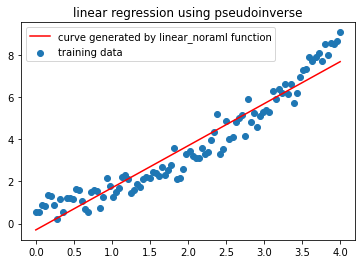

(6.732675, <Figure size 432x288 with 0 Axes>)

<Figure size 432x288 with 0 Axes>

In [304]:
plot_linear()

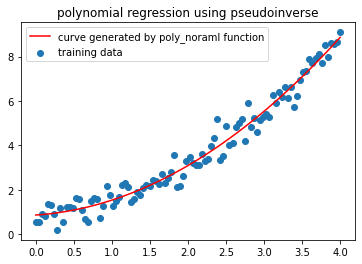

(4.0383377, <Figure size 432x288 with 0 Axes>)

<Figure size 432x288 with 0 Axes>

In [305]:
plot_poly()

In [332]:
x,y = load_xor_data()

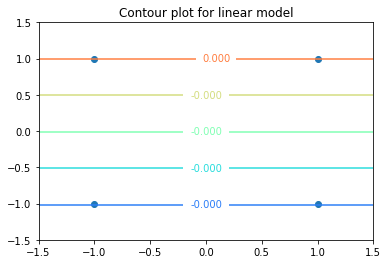

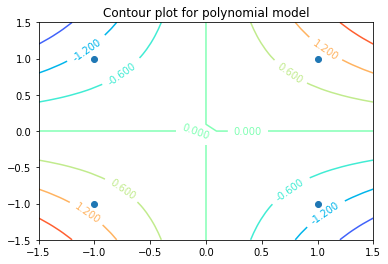

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [333]:
title('Contour plot for linear model')
scatter(x[:,0],x[:,1])
C = contour_plot(-1.5,1.5,-1.5,1.5,poly_xor()[0])
title('Contour plot for polynomial model')
scatter(x[:,0],x[:,1])
contour_plot(-1.5,1.5,-1.5,1.5,poly_xor()[1])

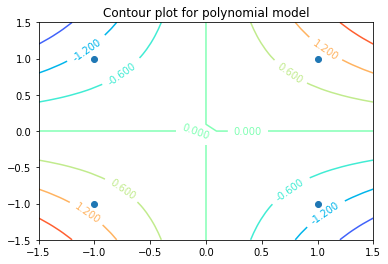

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [284]:
title('Contour plot for polynomial model')
scatter(x[:,0],x[:,1])
contour_plot(-1.5,1.5,-1.5,1.5,poly_xor()[1])

In [328]:
x,y = load_logistic_data()
w_log = logistic(x,y)
w_linear = linear_gd(x,y)
#scatter(x,y)
#plot(w)



In [329]:
w_log,w_linear

(tensor([[ 0.0720],
         [-0.5833],
         [ 1.4075]]),
 tensor([[ 0.0265],
         [-0.0785],
         [ 0.2556]]))

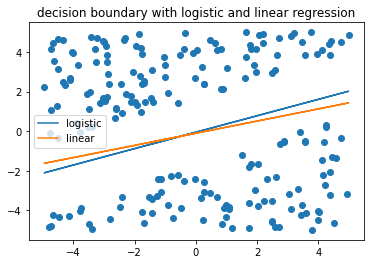

In [330]:
scatter(x[:,0],x[:,1],cmap=y)
plot(x[:,0],y_log,label='logistic')
plot(x[:,0],y_linear,label='linear')
title('decision boundary with logistic and linear regression')
legend()

In [321]:
y_log = -(w_log[0]+w_log[1]*x[:,0])/w_log[2]
y_linear = -(w_linear[0]+w_linear[1]*x[:,0])/w_linear[2]

In [318]:
w[2]

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [245]:
X,Y = load_xor_data()


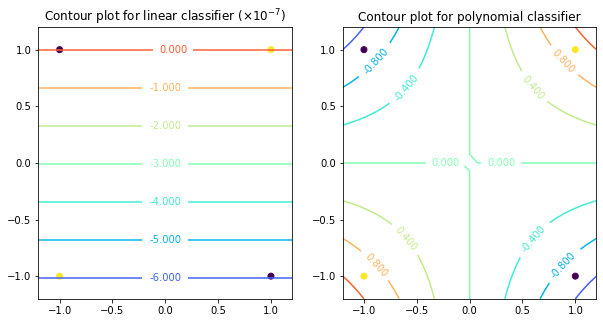

In [246]:
figure(figsize=[10,5])
subplot(1,2,1)
xgrid = torch.linspace(-1.2, 1.2, 33)
ygrid = torch.linspace(-1.2, 1.2, 33)
(xx, yy) = torch.meshgrid(xgrid, ygrid)

# Get predictions
features = torch.dstack((xx, yy)).reshape(-1, 2)
predictions = poly_xor()[0](features)

# Arrange predictions into grid and plot
zz = predictions.reshape(xx.shape)
C = contour(xx, yy, zz,cmap = 'rainbow')
clabel(C)
scatter(X[:,0],X[:,1],c=Y)
title('Contour plot for linear classifier ($\\times 10^{-7}$)')

subplot(1,2,2)
xgrid = torch.linspace(-1.2, 1.2, 33)
ygrid = torch.linspace(-1.2, 1.2, 33)
(xx, yy) = torch.meshgrid(xgrid, ygrid)

# Get predictions
features = torch.dstack((xx, yy)).reshape(-1, 2)
predictions = poly_xor()[1](features)

# Arrange predictions into grid and plot
zz = predictions.reshape(xx.shape)
C = contour(xx, yy, zz,cmap = 'rainbow')
clabel(C)
scatter(X[:,0],X[:,1],c=Y)
title('Contour plot for polynomial classifier')
savefig('Q4e_contour.png',dpi=100)


In [335]:
X,Y = load_xor_data()
[n,d] = X.shape
print(n,d)

4 2


In [341]:
def linear_normal(X,Y):
    [n,d]=X.shape
    X = torch.cat((torch.ones(n,1),X),1)
    X_inv = torch.pinverse(X)
    w = X_inv@Y
    return w

In [342]:
def prediction_linear(D):
    # training
    X,Y = load_xor_data()
    fit = linear_normal(X,Y)
    w = fit
    
    [n,d] = D.shape
    D = torch.cat((torch.ones([n,1]),D),1) # prepend 1 to D
    
    result = D@w
        
    return result*1e7

def prediction_poly(D):
    # training
    X,Y = load_xor_data()
    fit = poly_normal(X,Y)
    w = fit
    
    [n,d] = D.shape
    
    d_idx = 0
    while d_idx < d:
        p_idx = d_idx
        
        while p_idx < d:
            temp = D[:,d_idx] * D[:,p_idx]
            temp = temp.unsqueeze(1)
            D = torch.cat((D,temp),1)
            p_idx = p_idx + 1
        
        d_idx = d_idx + 1

    # prepend 1 to X       
    D = torch.cat((torch.ones([n,1]),D),1)  
    result = D@w

    return result

In [343]:
fit_poly = hw1.poly_normal(X,Y)
fit_linear = hw1.linear_normal(X,Y)

NameError: name 'hw1' is not defined

Text(0.5, 1.0, 'Contour plot for polynomial classifier')

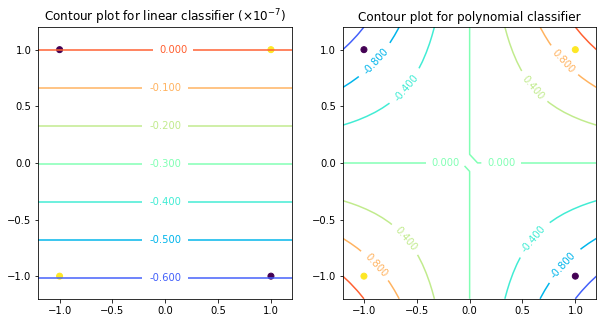

In [344]:
figure(figsize=[10,5])
subplot(1,2,1)
xgrid = torch.linspace(-1.2, 1.2, 33)
ygrid = torch.linspace(-1.2, 1.2, 33)
(xx, yy) = torch.meshgrid(xgrid, ygrid)

# Get predictions
features = torch.dstack((xx, yy)).reshape(-1, 2)
predictions = prediction_linear(features)

# Arrange predictions into grid and plot
zz = predictions.reshape(xx.shape)
C = contour(xx, yy, zz,cmap = 'rainbow')
clabel(C)
scatter(X[:,0],X[:,1],c=Y)
title('Contour plot for linear classifier ($\\times 10^{-7}$)')

subplot(1,2,2)
xgrid = torch.linspace(-1.2, 1.2, 33)
ygrid = torch.linspace(-1.2, 1.2, 33)
(xx, yy) = torch.meshgrid(xgrid, ygrid)

# Get predictions
features = torch.dstack((xx, yy)).reshape(-1, 2)
predictions = prediction_poly(features)

# Arrange predictions into grid and plot
zz = predictions.reshape(xx.shape)
C = contour(xx, yy, zz,cmap = 'rainbow')
clabel(C)
scatter(X[:,0],X[:,1],c=Y)
title('Contour plot for polynomial classifier')
#savefig('Q4e_contour.png',dpi=100)


In [ ]:
figure(figsize=(4,4))
linear_plot = hw1_utils.contour_plot(-1, 1, -1, 1, prediction_linear, ngrid = 100)
axes = linear_plot.add_subplot(1,1,1)
axes.scatter(X[:,0],X[:,1],c=Y)
#savefig('Q4e_contour_linear.png',dpi=100)
#title('Decision boundary w/ linear model')
figure(figsize=(4,4))
hw1_utils.contour_plot(-1, 1, -1, 1, prediction_poly, ngrid = 100)
#savefig('Q4e_contour_poly.png',dpi=100)
#title('Decision boundary w/ polynomial model')